## **EQUAZIONE DI SCHRÖDINGER**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

In meccanica quantstica, è un'equazione che descrive l'evoluzione temporale dello stato di un sistema.

$$
i \hbar \frac{\partial}{\partial t} \psi(\mathbf{r}, t) = \hat{H} \psi(\mathbf{r}, t)
$$

dove:

$i$ è l'unità immaginaria.

$r = (x, y, z)$ è un punto nello spazio tridimensionale. $dr = \frac{L}{N-1}$ con L lunghezza della regione spaziale e N numero di punti discreti nella griglia spaziale ("risoluzione", in quanti pezzi dividiamo la regione L).

$\psi(\mathbf{r}, t)$ è la funzione d'onda, ovvero l'ampiezza di probabilità di differenti configurazioni del sistema.

$\hbar$ la costante di Planck ridotta ($h/2 \pi$).

$\hat{H}$ è l'operatore hamiltoniano, pari a $
 -\frac{\hbar^2}{2m} \nabla^2 + V(\mathbf{r})
$, con $\nabla^2$ operatore laplaciano (seconda derivata spaziale) e $V(\mathbf{r})$ il potenziale.

L'equazione può essere riscritta come:

$$
i \hbar \frac{\partial}{\partial t} \psi(\mathbf{r}, t) = \left( -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial \mathbf{r}^2} + V(\mathbf{r}) \right) \psi(\mathbf{r}, t)
$$

quindi

$$
i \hbar \frac{\partial}{\partial t} \psi(\mathbf{r}, t) =  -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial \mathbf{r}^2} \psi(\mathbf{r}, t) + V(\mathbf{r})  \psi(\mathbf{r}, t)
$$

Questa è la versione dipendente dal tempo, in cui la funzione d'onda dipende sia dalla posizione r che dal tempo $t$, e l’operatore Hamiltoniano $\hat{H}$ descrive l’energia totale del sistema.

Descrive come la funzione d’onda evolve nel tempo, ed è un’equazione differenziale parziale di primo ordine rispetto al tempo e di secondo ordine rispetto alla posizione. In questo caso la risolviamo in una dimensione, quindi $\mathbf{r} = x$.

Il nostro obiettivo è calcolare  $\psi(x, t)$  a ogni istante di tempo  $t$ , a partire da un’condizione iniziale  $\psi(x, 0)$ .

In [21]:
# Costanti

m = 1.0
hbar = 1.0
L = 10.0
N = 1000
dr = L / (N-1) 
r = np.linspace(0, L, N)
V = np.zeros(N)
dt = 0.001  
T_steps = 1000 

$dt$ definisce il passo temporale, ovvero l’intervallo di tempo tra due calcoli successivi della funzione d’onda nella simulazione numerica. T_steps definisce il numero di passi.

Ora definiamo il potenziale (che attualmente è nullo ovunque); simuliamo un pozzo quadrato, definendo un potenziale diverso da zero in una determinata regione. In questo caso avremo un potenziale nullo al centro e alto ai bordi, nella regione $ [L/4, 3L/4]$.
Un pozzo quadrato è infatti un sistema in cui il potenziale è basso/nullo in une regione, e alto/infinito al di fuori di quella, nel nostro caso

$$
V(x) =
\begin{cases}
0 & \text{se } L/4 \leq x \leq 3L/4, \\
V_0 & \text{altrove}.
\end{cases}
$$


In [22]:
# Potenziale
V = np.zeros(N)
V[int(N/4):int(3*N/4)] = 1.0

Definiamo ora l'Hamiltoniano, che rappresenta l'energia totale del sistema, e che è quindi costituito dalla somma di energia cinetica e potenziale.

Il termine cinetico è:

$$
-\frac{\hbar^2}{2m} \nabla^2 \psi(x, t) $$

Per ottenere il laplaciano, che nel nostro caso a una dimensione è pari a: 
$$
\nabla^2 \psi(x) = \frac{\partial^2 \psi(x)}{\partial x^2}
$$
si usa il metodo delle differenze finite, approssimandolo: 
$$\frac{\partial^2 \psi(x)}{\partial x^2} \approx \frac{\psi(x+dr) - 2\psi(x) + \psi(x-dr)}{dr^2} \approx 1D \cdot \psi$$

dove $dr$ è la distanza tra due punti della griglia spaziale.
In pratica, in questo modo il laplaciano diventa una matrice 1D che agisce su $\psi$, 
$$
\text{con 1D}

= \frac{1}{(2x)^2}
\begin{bmatrix}
-2 &  1 &  0 &  0 &  0 \\
1 & -2 &  1 &  0 &  0 \\
0 &  1 & -2 &  1 &  0 \\
0 &  0 &  1 & -2 &  1 \\
0 &  0 &  0 &  1 & -2
\end{bmatrix}
$$


In [23]:
# Matrice tridiagonale per il termine cinetico
diagonal = -2.0 * np.ones(N)
off_diagonal = 1.0 * np.ones(N-1)
kinetic = (-hbar**2 / (2 * m * dr**2)) * sparse.diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1])

Il termine potenziale è semplicemente $
V(x) \psi(x, t)
$. 
Per calcolarlo creiamo una matrice diagonale sparsa (tanti zeri) con il potenziale lungo la diagonale.

In [24]:
# Termine potenziale
potential = sparse.diags(V)

In [25]:
# Hamiltoniano totale
H = kinetic + potential

Definiamo il metodo di integrazione temporale per risolvere l'equazione e scoprire come evolve $\psi (x, t)$. I metodi più comuni sono quello di Eulero, di Crank-Nicolson e di Runge-Kutta. Il metodo di Eulero, che è il più semplice, prevede un approccio instabile, dove usiamo direttamente $\psi (t)$ per calcolare $\psi (t + \delta t)$. 

Il metodo Crank-Nicolson usa invece una media tra presente e futuro per fare il passo temporale. Invece di usare solo  $\psi(t)$ , mescola informazioni da  $\psi(t)$  e  $\psi(t + \Delta t)$ . La formula è: 

$$
A \psi(t + \Delta t) = B \psi(t)
$$

ovvero

$$ I + i \frac{\Delta t}{2 \hbar} H \psi(t + \Delta t) = I - i \frac{\Delta t}{2 \hbar} H \psi(t)$$


con $I$ la matrice identità. In pratica, stiamo moltiplicando $\psi(t)$  e  $\psi(t + \Delta t)$ per lo stesso fattore, cambiando un segno.

In [26]:
# Matrici per il metodo Crank-Nicolson
I = sparse.identity(N)
A = (I + 1j * dt / (2 * hbar) * H)
B = (I - 1j * dt / (2 * hbar) * H)

Ora possiamo definire la funzione d'onda iniziale $ \psi(x, 0) $. Un esempio comune è la normale, centrata nella regione spaziale.

In [27]:
# Funzione d'onda iniziale --> gaussiana
psi = np.exp(-((r - L/2)**2) / 2)
psi = psi / np.linalg.norm(psi)  # Normalizzazione

Adesso facciamo evolvere la funzione d'onda nel tempo. 

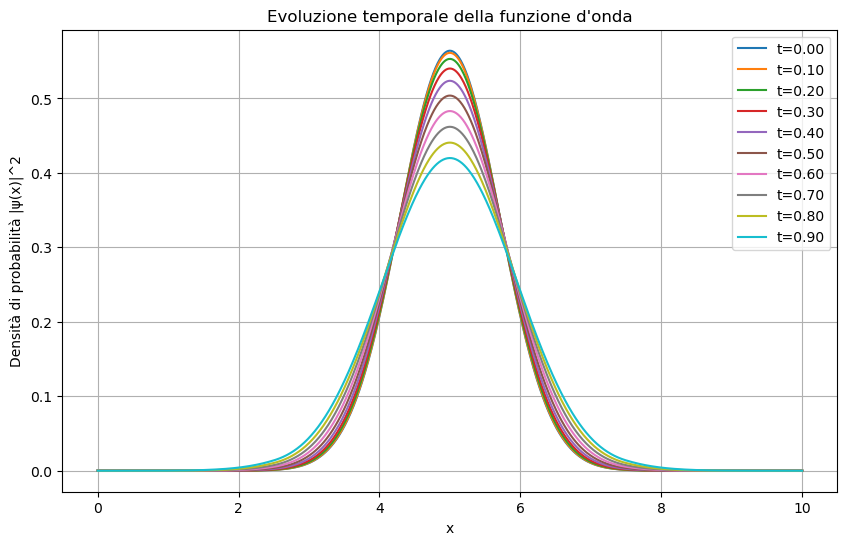

In [28]:
# Evoluzione temporale
plt.figure(figsize=(10, 6))
for t in range(T_steps):
    # Crank-Nicolson step
    psi = spsolve(A, B.dot(psi))
    
    # Normalizzazione
    psi = psi / np.sqrt(np.sum(np.abs(psi)**2) * dr)
    
    # Visualizzazione ogni 100 passi
    if t % 100 == 0:
        plt.plot(r, np.abs(psi)**2, label=f't={t*dt:.2f}')

plt.title("Evoluzione temporale della funzione d'onda")
plt.xlabel("x")
plt.ylabel("Densità di probabilità |\u03C8(x)|^2")
plt.legend()
plt.grid(True)
plt.show()

La particella è inizialmente collocata nel punto $r=5$.
Dal grafico possiamo osservare che, man mano che il tempo avanza, la densità si allarga e il picco si abbassa: la densità di probabilità si espande nello spazio $r$, aumentando le probabilità che la particella si trovi in punti più lontani (anche se di poco). Questo rappresenta il fenomeno di dispersione quantistica: la particella non rimane localizzata, ma si “diffonde” a causa del termine cinetico, legato al moto della particella.

Rieseguendo nuovamente l'ultima parte di codice, poiché la funzione di partenza non è più una gaussiana centrata in $x = L/2$, otterremo dei risultati completamente diversi.

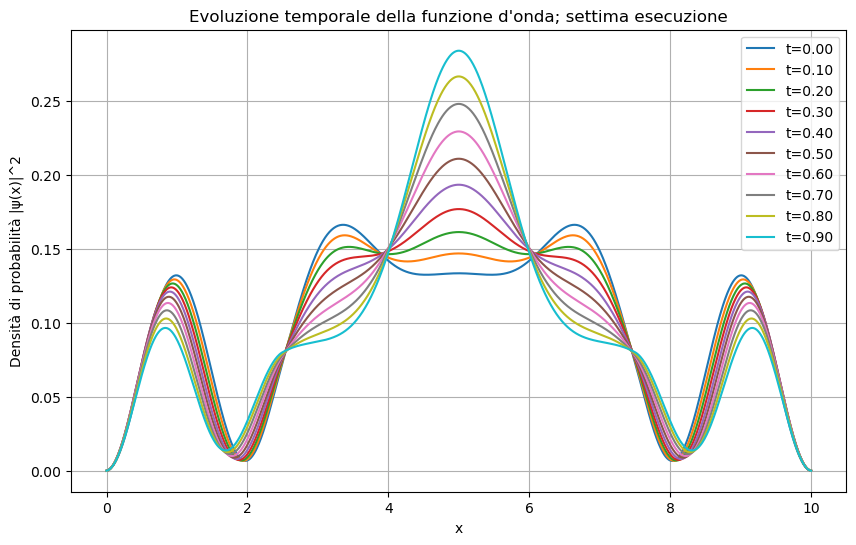

In [34]:
# Evoluzione temporale settima esecuzione
plt.figure(figsize=(10, 6))
for t in range(T_steps):
    # Crank-Nicolson step
    psi = spsolve(A, B.dot(psi))
    
    # Normalizzazione
    psi = psi / np.sqrt(np.sum(np.abs(psi)**2) * dr)
    
    # Visualizzazione ogni 100 passi
    if t % 100 == 0:
        plt.plot(r, np.abs(psi)**2, label=f't={t*dt:.2f}')

plt.title("Evoluzione temporale della funzione d'onda; settima esecuzione")
plt.xlabel("x")
plt.ylabel("Densità di probabilità |\u03C8(x)|^2")
plt.legend()
plt.grid(True)
plt.show()

Qui il codice completo. Notiamo subito che, cambiando la massa, i risultati cambiano notevolmente. Se la massa aumenta (es m=10) il risultato sarà praticamente una sola distribuzione normale, se invece è molto piccola otteniamo un risultato più "disordinato".

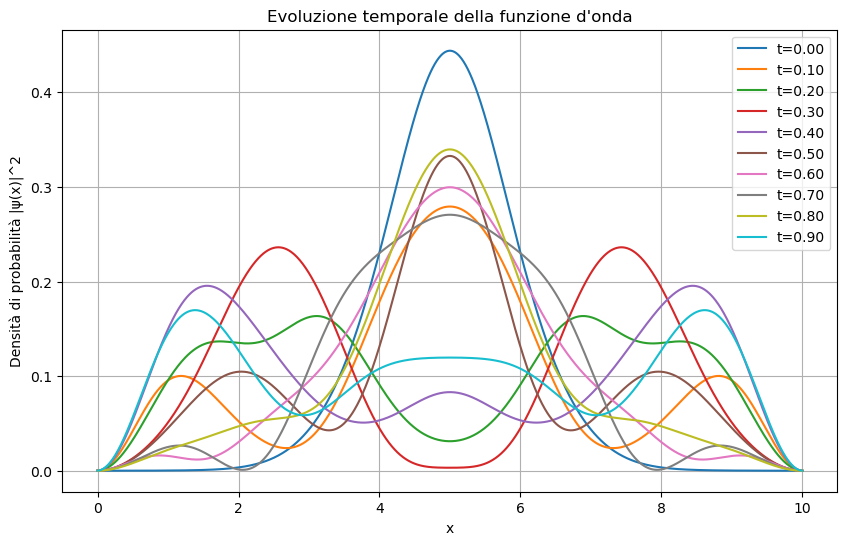

In [39]:
# Codice completo

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Costanti
m = 0.001
hbar = 1.0
L = 10.0
N = 1000
dr = L / (N-1) 
r = np.linspace(0, L, N)
V = np.zeros(N)
dt = 0.001  
T_steps = 1000 

# Potenziale
V = np.zeros(N)
V[int(N/4):int(3*N/4)] = 1.0

# Matrice tridiagonale per il termine cinetico
diagonal = -2.0 * np.ones(N)
off_diagonal = 1.0 * np.ones(N-1)
kinetic = (-hbar**2 / (2 * m * dr**2)) * sparse.diags([off_diagonal, diagonal, off_diagonal], [-1, 0, 1])

# Termine potenziale
potential = sparse.diags(V)

# Hamiltoniano totale
H = kinetic + potential

# Matrici per il metodo Crank-Nicolson
I = sparse.identity(N)
A = (I + 1j * dt / (2 * hbar) * H)
B = (I - 1j * dt / (2 * hbar) * H)

# Funzione d'onda iniziale --> gaussiana
psi = np.exp(-((r - L/2)**2) / 2)
psi = psi / np.linalg.norm(psi) 

# Evoluzione temporale
plt.figure(figsize=(10, 6))
for t in range(T_steps):
    psi = spsolve(A, B.dot(psi))
    psi = psi / np.sqrt(np.sum(np.abs(psi)**2) * dr)
    

    if t % 100 == 0:
        plt.plot(r, np.abs(psi)**2, label=f't={t*dt:.2f}')

plt.title("Evoluzione temporale della funzione d'onda")
plt.xlabel("x")
plt.ylabel("Densità di probabilità |\u03C8(x)|^2")
plt.legend()
plt.grid(True)
plt.show()

